In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import networkx as nx

### Load the dataset

In [26]:
# The column names for the dataset
# They are not provided in the original code, so we define them here.

COLS = [
    "unit", "cycle",
    "setting1", "setting2", "setting3",
    "T2", "T24", "T30", "T50", "P2", "P15", "P30",
    "Nf", "Nc", "EPR", "Ps30", "Phi", "NRf", "NRc",
    "BPR", "farB", "htBleed", "Nf_dmd", "PCNf_Rdmd", "W31", "W32"
]

In [27]:
# Importing the train dataset

df = pd.read_csv(
    "data/train_FD001.txt",
    delim_whitespace=True,   # gère les espaces multiples
    header=None,             # pas d’entêtes dans le .txt
    names=COLS,              # on assigne notre liste
    usecols=range(len(COLS)) # ignore les colonnes vides finales
)

df.head()

C:\Users\Samue\AppData\Local\Temp\ipykernel_21012\237424015.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,Phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [28]:
# Importing the test dataset

df_test = pd.read_csv(
	"data/test_FD001.txt",
	delim_whitespace=True,
	header=None,
	names=COLS,
	usecols=range(len(COLS))
)

df_test.head()

C:\Users\Samue\AppData\Local\Temp\ipykernel_21012\2599212678.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv(


,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,Phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [29]:
def add_rul(df):
    temp = df.groupby('unit')['cycle'].max().reset_index()
    temp.columns = ['unit', 'max_cycle']
    df = df.merge(temp, on='unit')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df.drop('max_cycle', axis=1)

# Adding RUL to the train and test datasets
df = add_rul(df)
df_test = add_rul(df_test)

df.head()

,unit,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNf_Rdmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Calcul Remaining Useful Life (RUL) to labelised the cycles

Data conversion

In [60]:
WINDOW = 25     # window length
HORIZON = 50    # alert if RUL ≤ HORIZON

def flag_window(win, p10, p90):
    """
    Converts a window (DataFrame) into a set of readable 'binary features'.
    """
    fset = set()
    for col in SENSOR_COLS:
        series = win[col]
        # Static: extreme values
        if series.mean() >= p90[col]:
            fset.add(f"{col}_High")
        elif series.mean() <= p10[col]:
            fset.add(f"{col}_Low")
        # Dynamic: trend
        slope = series.iloc[-1] - series.iloc[0]
        if slope > 0:
            fset.add(f"{col}_Rising")
        elif slope < 0:
            fset.add(f"{col}_Falling")
    return fset

SENSOR_COLS = ['T2','T24','T30','T50','P2','P15','P30',
               'Nf','Nc','EPR','Ps30','Phi','NRf','NRc',
               'BPR','farB','htBleed','Nf_dmd','PCNf_Rdmd','W31','W32']
p10 = df[SENSOR_COLS].quantile(0.10)
p90 = df[SENSOR_COLS].quantile(0.90)

df_all = df.copy()          # save

transactions = []
labels = []
unit_ids = []
start_indices = []

for uid, df_unit in tqdm(df_all.groupby('unit')):
    for start in range(0, len(df_unit) - WINDOW + 1):
        win = df_unit.iloc[start:start+WINDOW]
        features = flag_window(win, p10, p90)
        label = "Fail≤50" if win['RUL'].iloc[-1] <= HORIZON else "Healthy"
        features.add(label)  # <<––– AJOUT ICI
        transactions.append(features)
        labels.append(label)
        unit_ids.append(uid)
        start_indices.append(start)

# Convert transactions to DataFrame using TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# Create DataFrame with all information
transactions_df = pd.DataFrame(te_ary, columns=te.columns_)
transactions_df['label'] = labels
transactions_df['unit'] = unit_ids
transactions_df['window_start'] = start_indices

# Verify dimensions
calc = (df_all.groupby('unit')['cycle'].max() - WINDOW + 1).sum()
print("Expected:", int(calc), "  Obtained:", len(transactions_df))
assert len(transactions_df) == calc

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]

Expected: 18231   Obtained: 18231


Verificaiton nb_windows = total_cycles - WINDOW + 1

In [61]:
calc = (df.groupby('unit')['cycle'].max() - WINDOW + 1).sum()
print("Expected :", int(calc), "  Obtained :", len(transactions))
assert len(transactions) == calc


Expected : 18231   Obtained : 18231


In [62]:
print("Sample transaction:", transactions[0]) 
print("Available features:", set.union(*transactions))

Sample transaction: {'Ps30_Falling', 'farB_High', 'Phi_Rising', 'T30_Rising', 'NRc_Falling', 'W32_Rising', 'htBleed_Rising', 'Nc_Rising', 'T2_High', 'P15_High', 'W31_Falling', 'BPR_Falling', 'T24_Rising', 'PCNf_Rdmd_High', 'Healthy', 'P2_High', 'P30_Falling', 'Nf_Falling', 'Nf_dmd_High', 'T50_Falling', 'EPR_High'}
Available features: {'NRf_Rising', 'T30_Low', 'T50_High', 'T30_Rising', 'T30_Falling', 'T24_Low', 'htBleed_Rising', 'T2_High', 'P15_High', 'W32_High', 'Ps30_High', 'Nc_High', 'T50_Rising', 'P15_Rising', 'BPR_Falling', 'NRc_Low', 'T24_Rising', 'T24_Falling', 'P15_Falling', 'Ps30_Rising', 'Healthy', 'P2_High', 'W32_Low', 'W31_High', 'P30_Falling', 'Phi_High', 'Nf_Rising', 'P30_Rising', 'T24_High', 'Nf_dmd_High', 'T50_Falling', 'P15_Low', 'htBleed_High', 'BPR_Low', 'Ps30_Low', 'NRc_High', 'NRc_Rising', 'Ps30_Falling', 'W31_Low', 'Nf_Low', 'htBleed_Falling', 'Nc_Falling', 'W31_Rising', 'farB_High', 'T50_Low', 'Phi_Rising', 'NRf_Falling', 'Phi_Low', 'NRc_Falling', 'Nc_Low', 'W32_R

### Data visualisation

Compt of the number of transactions per unit

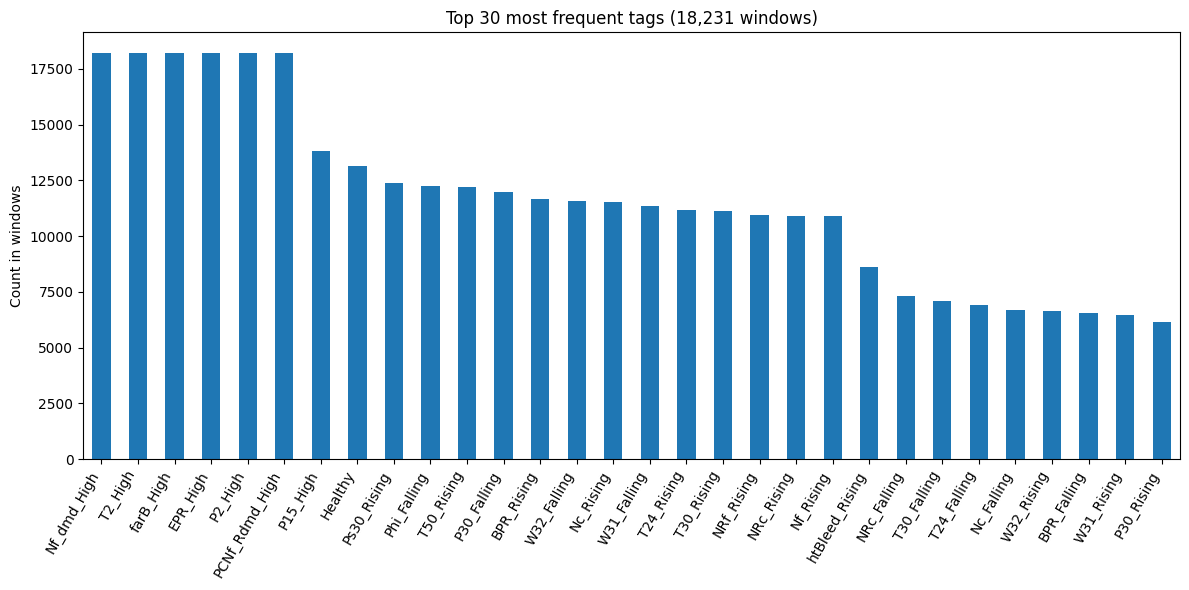

In [63]:
freq = transactions_df.drop(columns=['label', 'unit', 'window_start']).sum().sort_values(ascending=False)
top_n = 30            # number of most frequent tags to display
freq_head = freq.head(top_n)

plt.figure(figsize=(12, 6))
freq_head.plot(kind='bar')
plt.title(f"Top {top_n} most frequent tags ({len(transactions_df):,} windows)")
plt.ylabel("Count in windows")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


### Specific cleaning

Some of the values can be constant. In this case we should delet those uniformative values  

In [64]:
data_full = transactions_df.drop(columns=['label','unit','window_start'])
constant_features_full = data_full.columns[data_full.nunique() == 1]
print("Constant features (full):", constant_features_full.tolist())
data_full_cleaned = data_full.drop(columns=constant_features_full)

print(f"Original shape (full): {data_full.shape}")
print(f"Cleaned shape (full): {data_full_cleaned.shape}")

Constant features (full): ['EPR_High', 'Nf_dmd_High', 'P2_High', 'PCNf_Rdmd_High', 'T2_High', 'farB_High']
Original shape (full): (18231, 68)
Cleaned shape (full): (18231, 62)


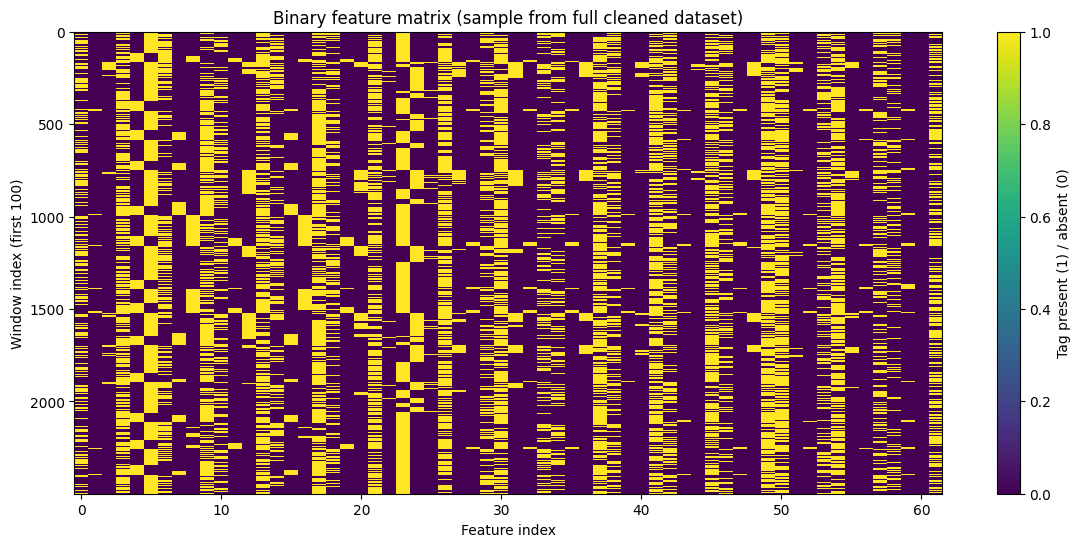

In [65]:
sample_size = 2500     # show 100 windows
sampled_data = data_full_cleaned.iloc[:sample_size]

plt.figure(figsize=(14, 6))
plt.imshow(sampled_data.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='Tag present (1) / absent (0)')
plt.xlabel("Feature index")
plt.ylabel("Window index (first 100)")
plt.title("Binary feature matrix (sample from full cleaned dataset)")
plt.show()

In [66]:
failure_windows = transactions_df[transactions_df['label'] == 'Fail≤50']
failure_data = failure_windows.drop(columns=['label', 'unit', 'window_start'])

In [67]:
common_features = failure_data.columns[(failure_data.sum() / len(failure_data)) > 0.05]
failure_data = failure_data[common_features]

## Model training

In [68]:
from mlxtend.frequent_patterns import apriori, association_rules

failure_windows_sampled = failure_windows.sample(n=2000, random_state=42)
failure_data = failure_windows_sampled.drop(columns=['label', 'unit', 'window_start'])


frequent_itemsets = apriori(
    failure_data,
    min_support=0.1,
    use_colnames=True,
    max_len=3  # par exemple : max 3 éléments par itemset
)


# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by lift
rules = rules.sort_values(by='lift', ascending=False)

# Show top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


                 antecedents            consequents  support  confidence  \
2616   (T50_High, Ps30_High)             (BPR_High)   0.1050    0.792453   
2617              (BPR_High)  (T50_High, Ps30_High)   0.1050    0.840000   
2618              (T50_High)  (BPR_High, Ps30_High)   0.1050    0.688525   
2615   (BPR_High, Ps30_High)             (T50_High)   0.1050    0.958904   
28737            (Ps30_High)     (P30_Low, W31_Low)   0.1005    0.648387   
28732     (P30_Low, W31_Low)            (Ps30_High)   0.1005    0.966346   
31372   (W31_Low, Ps30_High)             (T50_High)   0.1075    0.942982   
31377             (T50_High)   (W31_Low, Ps30_High)   0.1075    0.704918   
28714    (P30_Low, T50_High)            (Ps30_High)   0.1140    0.957983   
28719            (Ps30_High)    (P30_Low, T50_High)   0.1140    0.735484   

           lift  
2616   6.339623  
2617   6.339623  
2618   6.287896  
2615   6.287896  
28737  6.234491  
28732  6.234491  
31372  6.183492  
31377  6.183492  
2

c:\Users\Samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


### Result visualisation

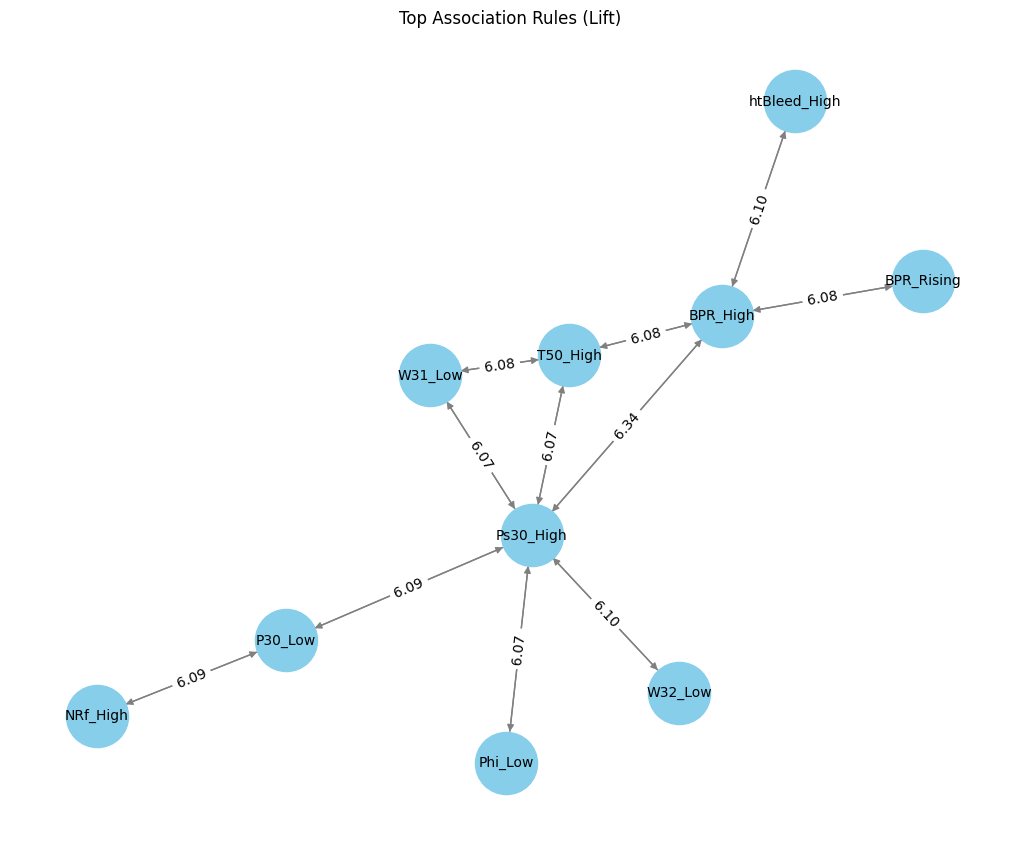

In [69]:
# Visualize top 20 rules using a graph
top_rules = rules.head(25)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            G.add_edge(ant, cons, weight=row['lift'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title("Top Association Rules (Lift)")
plt.show()


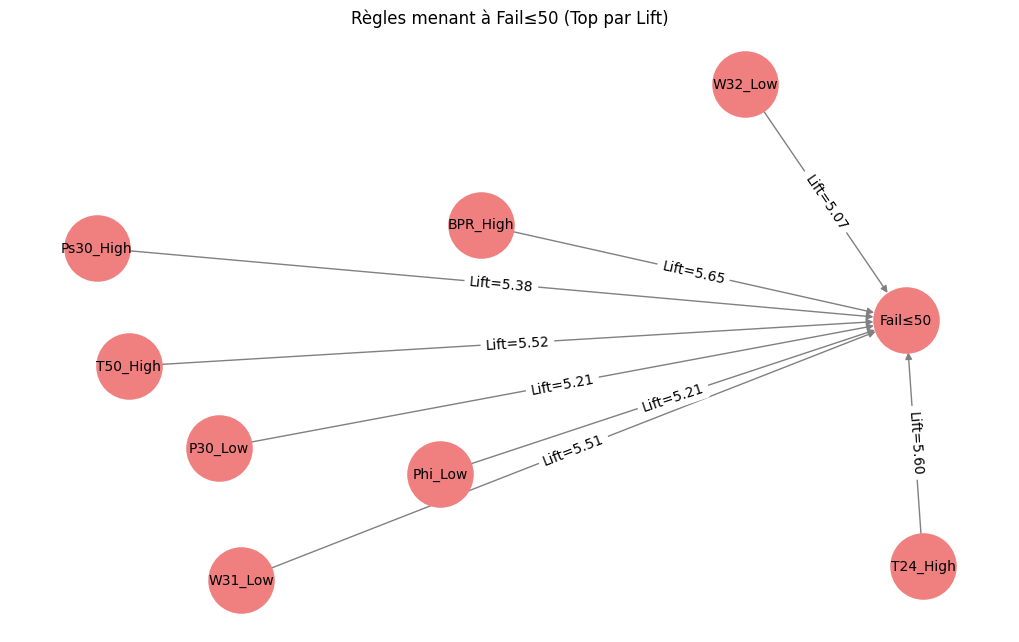

In [71]:
# Filtrer les règles dont la conséquence est 'Fail≤50'
rules_fail = rules[rules['consequents'].apply(lambda x: 'Fail≤50' in x)]

# Sélectionner les 10 meilleures règles (par lift)
top_rules_fail = rules_fail.sort_values(by='lift', ascending=False).head(25)

# Créer un graphe orienté
G = nx.DiGraph()

# Ajouter les arêtes pour chaque règle
for _, row in top_rules_fail.iterrows():
    for ant in row['antecedents']:
        G.add_edge(ant, 'Fail≤50', weight=row['lift'])  # toutes les flèches vont vers 'Fail≤50'

# Dessiner le graphe
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=2200, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"Lift={v:.2f}" for k, v in edge_labels.items()})
plt.title("Règles menant à Fail≤50 (Top par Lift)")
plt.show()
